# Assignment 18/03/2025

## Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
from IPython.display import display, clear_output
from PIL import Image
import time

## 1. Frame Difference

### Loading video

In [ ]:
video_path = '../videos/Hall 8.avi'

In [ ]:
cap = cv2.VideoCapture(video_path)

In [ ]:
# Read the first frame
ret, current_frame = cap.read()
previous_frame = current_frame

### Frame Manipulation

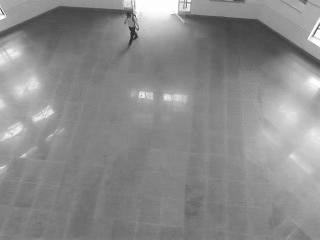

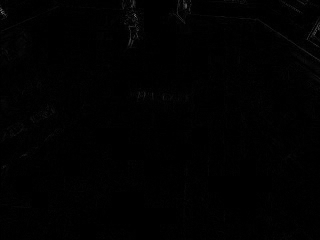

KeyboardInterrupt: 

In [18]:
# REFERENCING: https://stackoverflow.com/questions/33926000
while cap.isOpened():
    current_frame_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    previous_frame_gray = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)    

    frame_diff = cv2.absdiff(current_frame_gray, previous_frame_gray)

    frame_rgb = cv2.cvtColor(frame_diff, cv2.COLOR_GRAY2RGB)
    img_pil = Image.fromarray(frame_rgb)
    
    clear_output(wait=True)
    display(Image.fromarray(current_frame_gray), img_pil)

    # Read the next frame
    previous_frame = current_frame.copy()
    ret, current_frame = cap.read()

    if not ret:
        break

    time.sleep(0.05)

cap.release()

## 2. Background Modeling - Average

### Loading video

In [ ]:
# REFERENCING: https://github.com/rajan9519/Background-subtraction
cap = cv2.VideoCapture(video_path)

images = []

### Frame Manipulation

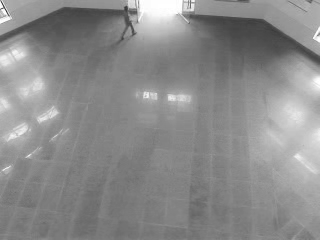

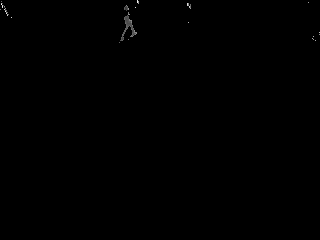

KeyboardInterrupt: 

In [23]:
while cap.isOpened():
    ret,frame = cap.read()
    #converting images into grayscale       
    frame_gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

    images.append(frame_gray)
    # removing the images after every 50 image
    if len(images)==50:
            images.pop(0)

    image = np.array(images)
    val = 25
    image = np.mean(image,axis=0)
    image = image.astype(np.uint8)
    # cv2.imshow('background',image)
    image = image.astype(np.uint8)
    # foreground will be background - curr frame
    foreground_image = cv2.absdiff(frame_gray,image)

    a = np.array([0],np.uint8)
    b = np.array([255],np.uint8)

    img = np.where(foreground_image>val,frame_gray,a)
    # cv2.imshow('foreground',img)
    clear_output(wait=True)
    display(Image.fromarray(frame_gray), Image.fromarray(img))
    
    time.sleep(0.01)

cap.release()

## 3. Background Modeling - Median

### Loading video

In [26]:
cap = cv2.VideoCapture(video_path)
images = []

### Frame Manipulation

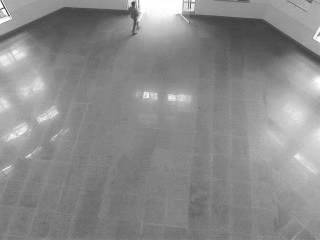

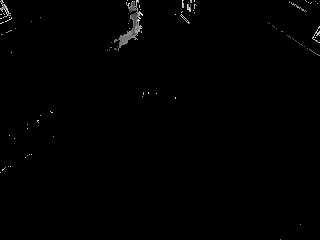

KeyboardInterrupt: 

In [27]:
while cap.isOpened():
    ret,frame = cap.read()
    #converting images into grayscale       
    frame_gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

    images.append(frame_gray)
    # removing the images after every 50 image
    if len(images)==50:
            images.pop(0)

    image = np.array(images)
    val = 10
    image = np.median(image,axis=0)
    image = image.astype(np.uint8)
    # cv2.imshow('background',image)
    image = image.astype(np.uint8)
    # foreground will be background - curr frame
    foreground_image = cv2.absdiff(frame_gray,image)

    a = np.array([0],np.uint8)
    b = np.array([255],np.uint8)

    img = np.where(foreground_image>val,frame_gray,a)
    # cv2.imshow('foreground',img)
    clear_output(wait=True)
    display(Image.fromarray(frame_gray), Image.fromarray(img))
    
    time.sleep(0.01)

cap.release()

## 4. Gaussian Mixture Model (GMM)

### Loading video

In [ ]:
# REFERENCING: https://docs.opencv.org/4.x/d1/dc5/tutorial_background_subtraction.html
backSub = cv2.createBackgroundSubtractorMOG2()

cap = cv2.VideoCapture(video_path)

### Frame Manipulation

In [ ]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Stop if end of video

    fgMask = backSub.apply(frame)

    # Convert frames for display
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mask_rgb = cv2.cvtColor(fgMask, cv2.COLOR_GRAY2RGB)

    img_frame = Image.fromarray(frame_rgb)
    img_mask = Image.fromarray(mask_rgb)

    clear_output(wait=True)
    display(img_frame, img_mask)

    time.sleep(0.05)

cap.release()

## 5. Kalman Filter - Tracking position

### Loading video

In [ ]:
backSub = cv2.createBackgroundSubtractorMOG2()

cap = cv2.VideoCapture(video_path)

### Initializing Kalman Matrices 

In [4]:
# REFERENCING: https://pieriantraining.com/kalman-filter-opencv-python-example/

# Initialize Kalman filter
kalman = cv2.KalmanFilter(4, 2)  # 4 state variables (x, y, dx, dy), 2 measurements (x, y)
kalman.measurementMatrix = np.array([[1, 0, 0, 0], 
                                     [0, 1, 0, 0]], np.float32)
kalman.transitionMatrix = np.array([[1, 0, 1, 0], 
                                    [0, 1, 0, 1], 
                                    [0, 0, 1, 0], 
                                    [0, 0, 0, 1]], np.float32)
kalman.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03  # Process noise

### Frame Manipulation

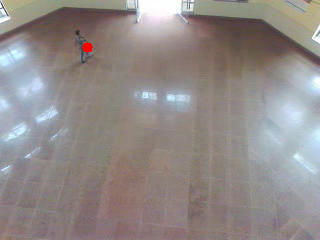

KeyboardInterrupt: 

In [4]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Stop if end of video

    # Apply background subtraction
    fgMask = backSub.apply(frame)

    # Find contours of moving objects
    contours, _ = cv2.findContours(fgMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    measurement = None

    for cnt in contours:
        if cv2.contourArea(cnt) > 500:  # Filter small objects
            x, y, w, h = cv2.boundingRect(cnt)
            measurement = np.array([[np.float32(x + w / 2)], 
                                    [np.float32(y + h / 2)]])  # Object centroid

            # Update Kalman filter with measurement
            kalman.correct(measurement)


    # Predict next position
    prediction = kalman.predict()
    pred_x, pred_y = int(prediction[0]), int(prediction[1])

    # Draw detection and tracking
    if measurement is not None:
        cv2.circle(frame, (int(measurement[0]), int(measurement[1])), 5, (0, 255, 0), -1)  # Detected object

    cv2.circle(frame, (pred_x, pred_y), 5, (0, 0, 255), -1)  # Kalman predicted position

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_frame = Image.fromarray(frame_rgb)

    clear_output(wait=True)
    display(img_frame)

    time.sleep(0.05)
    
cap.release()